# Gromov-Wasserstein 

In [1]:
import seaborn as sns
import numpy as np
import os,sys
module_path = os.path.abspath(os.path.join('/Users/vayer/Documents/OT/Python/GW_tests/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graph import *
import copy


# Construct Laetitia's trees

### Construire l'arbre à partir d'un xml

In [2]:
file_name='/Users/vayer/Documents/OT/Python/mercedData/agricultural/agricultural00.xml'

In [3]:
graph=Graph()
graph.build_Xml_tree(file_name,max_depth=2)

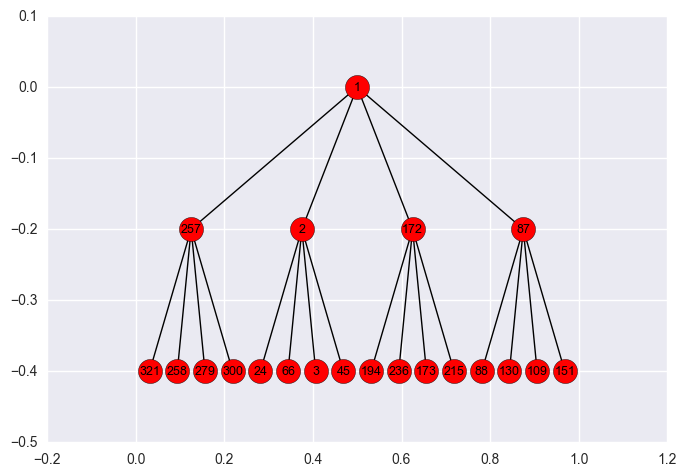

In [4]:
graph.display_graph(G=graph.nx_graph,pos=graph.hierarchy_pos(G=graph.nx_graph,root=1),node_size=300,font_size=9,figsize=(10,10))

# Transport optimal between two trees

In [5]:
import ot
import WGW_2 as wgw

In [6]:
file_name1='/Users/vayer/Documents/OT/Python/mercedData/agricultural/agricultural00.xml'
file_name2='/Users/vayer/Documents/OT/Python/mercedData/agricultural/agricultural81.xml'

In [7]:
graph1=Graph()
graph1.build_Xml_tree(file_name1,max_depth=3)
graph2=Graph()
graph2.build_Xml_tree(file_name2,max_depth=3)

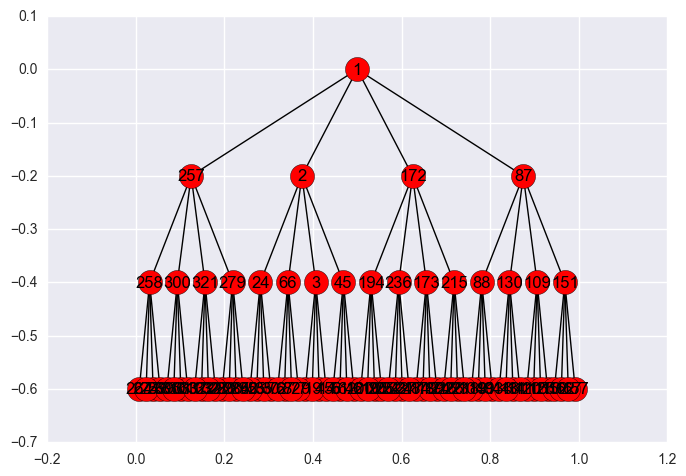

In [8]:
graph1.display_graph(G=graph1.nx_graph,pos=graph1.hierarchy_pos(graph1.nx_graph,1))

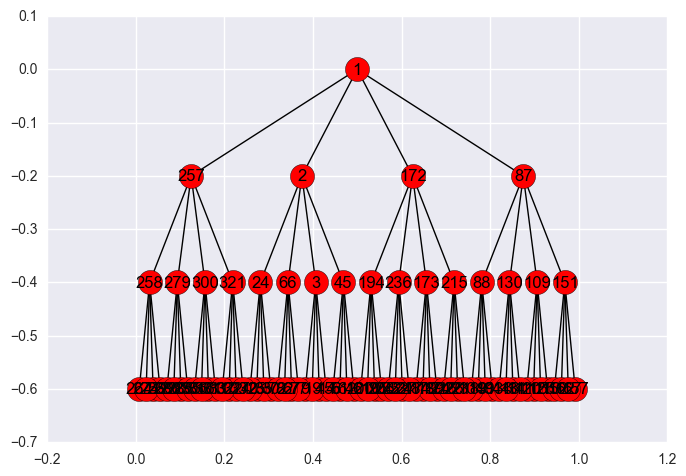

In [9]:
graph2.display_graph(G=graph2.nx_graph,pos=graph2.hierarchy_pos(graph2.nx_graph,1))

## Compute distance for trees beetween attributes

In [10]:
import matplotlib.gridspec as gridspec

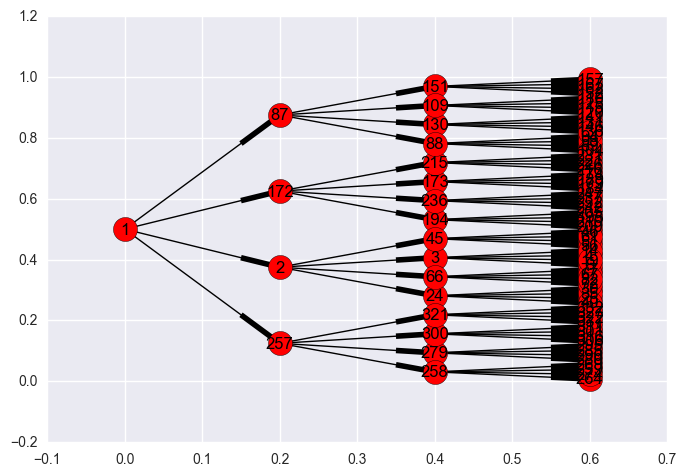

In [11]:
graph2.display_graph(graph2.tree,pos=graph2.hierarchy_pos(graph2.nx_graph,1,rotate=True))

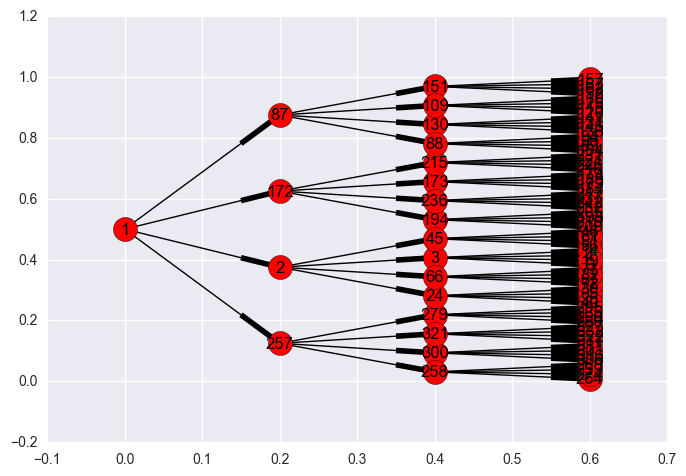

In [12]:
graph1.display_graph(graph1.tree,pos=graph1.hierarchy_pos(graph1.nx_graph,1,rotate=True))

### Ground Metric

In [13]:
x1=graph1.leaves_matrix_attr()
x2=graph2.leaves_matrix_attr()

In [14]:
M=ot.dist(x1,x2)
M= M/np.max(M)

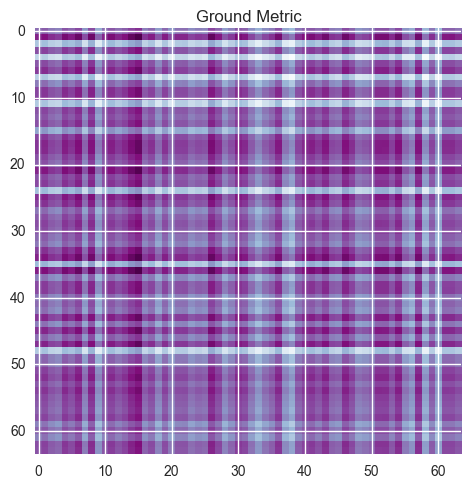

In [15]:
plt.imshow(M, cmap=plt.cm.BuPu,interpolation='nearest')
plt.title("Ground Metric")
plt.show()

### Costs matrix between leaves (both the same)

In [16]:
leaves1=graph1.return_leaves(graph1.tree)
leaves2=graph2.return_leaves(graph2.tree)
C1=graph1.distance_matrix(graph1.nx_graph,nodeOfInterest=leaves1)
C2=graph2.distance_matrix(graph2.nx_graph,nodeOfInterest=leaves2)

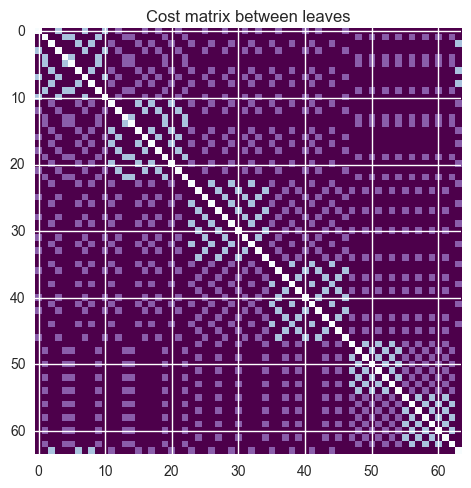

In [17]:
plt.imshow(C1, cmap=plt.cm.BuPu,interpolation='nearest')
plt.title("Cost matrix between leaves")
plt.show()

### Weights

In [18]:
t1masses = np.ones(len(leaves1))/len(leaves1)
t2masses = np.ones(len(leaves2))/len(leaves2)

### Classical transport

In [19]:
transp = ot.emd(t1masses,t2masses, M)

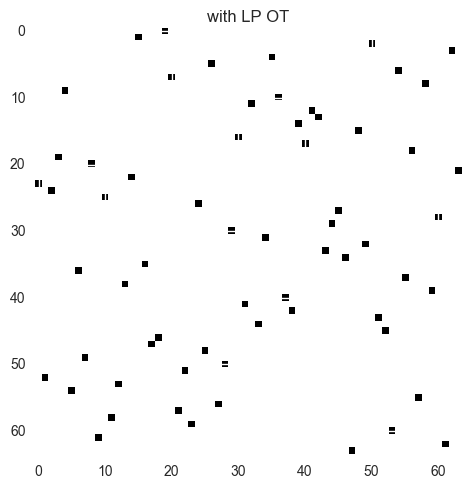

In [20]:
plt.imshow(transp, cmap=plt.cm.Greys,interpolation='nearest')
plt.title("with LP OT")
plt.show()

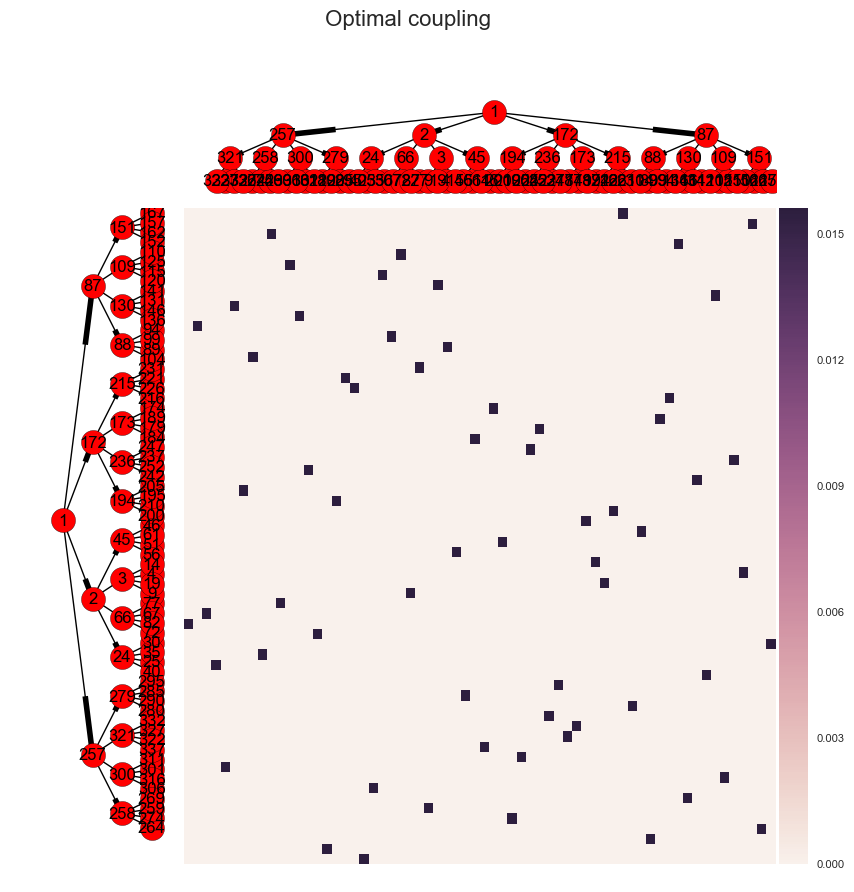

In [28]:
sns.set_context("paper")
f = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(2, 3, width_ratios=[1,4,0.2], height_ratios=[0.7,4])
gs.update(wspace=0.01, hspace=0.01)

ax2 = plt.subplot(gs[1])
sns.set_style('white')
ax2.axis('off')
plt.xlim( -0.05,1 )
nx.draw_networkx(graph2.tree,pos=graph2.hierarchy_pos(graph2.nx_graph,1))
ax3 = plt.subplot(gs[3])
plt.ylim( -0.05,1 )
nx.draw_networkx(graph1.tree,pos=graph1.hierarchy_pos(graph1.nx_graph,1,rotate=True))
ax3.axis('off')
ax5 = plt.subplot(gs[5])
ax4 = plt.subplot(gs[4])
sns.heatmap(np.flipud(transp),annot=True,fmt='.2f',cbar_ax=ax5,xticklabels=False,yticklabels=False)
f.suptitle('Optimal coupling', fontsize=16)
plt.show()

### Gromov transport

On veut trouver les paramètres alpha et epsilon qui entraine un transport qui prend en compte la structure. Le critère qu'on se donne est que les feuilles qui font partie du même noeud doivent être transportées au même endroit. Aussi la somme par block de 4 doit être la plus proche de 4. On appelle distance au transport structuré "parfait" le nombre de blocks de 4 dont la somme est égale à 4.
On compute aussi le cout (qui est la valeur de la distance de gromov wasser)

In [21]:
alphas=np.linspace(0,700,30)
epsilons= np.linspace(0.01,20,50)

In [77]:
i=0
j=0
dist=np.zeros(shape=(len(epsilons),len(alphas)))
cout=np.zeros(shape=(len(epsilons),len(alphas)))
for epsilon in epsilons:
    for alpha in alphas:
        transpwgw= wgw.wgw(M,C1,C2,t1masses,t2masses, 'square_loss',epsilon,alpha,max_iter=500,verbose=False,log=False)
        #dist[i,j]=np.sum((transpwgw-np.diag(transpwgw))<1.e-5)-transpwgw.shape[0] # nombre d'éléments nuls en dehors de la diagonale
        #cout[i,j]=np.sum(M+alpha*wgw.tensor_square_loss(C1,C2,transpwgw)+epsilon*np.nan_to_num(transpwgw*np.log(transpwgw))-transpwgw)
        transpwgw[transpwgw<1e-5]=0 #en dessous on considère le transport comme négligeable
        cout[i,j]=np.sum(transpwgw*M)
        dist[i,j]=np.sum(np.count_nonzero(utils.blockshaped(transpwgw,4,4),axis=1).sum(1)==4)
        j=j+1
    j=0
    i=i+1

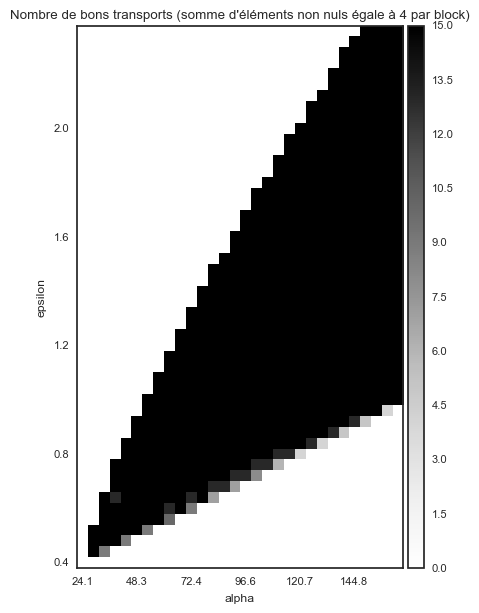

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
plt.figure(figsize=(5,7))
sns.set_context("paper")
ax = plt.gca()
im =plt.imshow(dist,interpolation='nearest')
plt.title("Nombre de bons transports (somme d'éléments non nuls égale à 4 par block)")
plt.xlabel('alpha')
plt.ylabel('epsilon')
plt.gca().invert_yaxis()
ax = plt.gca()
ax.set_xticklabels([ '%.1f' % elem for elem in alphas ])
ax.set_yticklabels([ '%.1f' % elem for elem in epsilons ])
#ax.set_xticklabels(alphas)
#ax.set_yticklabels(epsilons)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

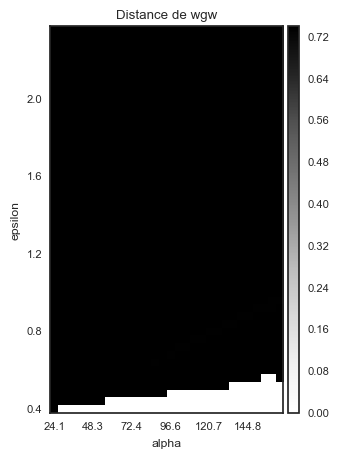

In [79]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
plt.figure(figsize=(10,5))
sns.set_context("paper")
ax = plt.gca()
im =plt.imshow(cout,interpolation='nearest')
plt.title("Distance de wgw")
plt.xlabel('alpha')
plt.ylabel('epsilon')
plt.gca().invert_yaxis()
ax = plt.gca()
ax.set_xticklabels([ '%.1f' % elem for elem in alphas ])
ax.set_yticklabels([ '%.1f' % elem for elem in epsilons ])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [80]:
indices_max = np.where(dist == dist.max())
indices_min_dist = np.where(cout == cout.min())

In [22]:
#alpha = alphas[indices_max[0][0]]
#epsilon=epsilons[indices_max[1][0]]
alpha = alphas[10]
epsilon=epsilons[13]

ot.tic()
transpwgw= wgw.wgw(M,C1,C2,t1masses,t2masses,'square_loss',epsilon,alpha,max_iter=500,verbose=False,log=False)
ot.toc()

Elapsed time : 0.018965959548950195 s


0.018965959548950195

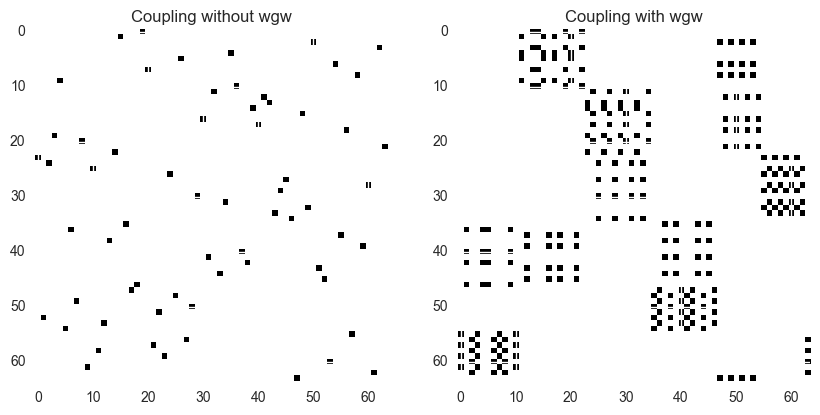

In [23]:
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(transp, cmap=plt.cm.Greys,interpolation='nearest')
plt.title("Coupling without wgw")
plt.subplot(122)
plt.imshow(transpwgw, cmap=plt.cm.Greys,interpolation='nearest')
plt.title("Coupling with wgw")
plt.show()

In [83]:
transpwgw2=transpwgw
transpwgw2[transpwgw2<1e-7]=0
np.sum(np.count_nonzero(utils.blockshaped(transpwgw2,4,4),axis=1).sum(1)==4)

15

In [84]:
np.sum(np.count_nonzero(utils.blockshaped(transp,4,4),axis=1).sum(1)==4)

0

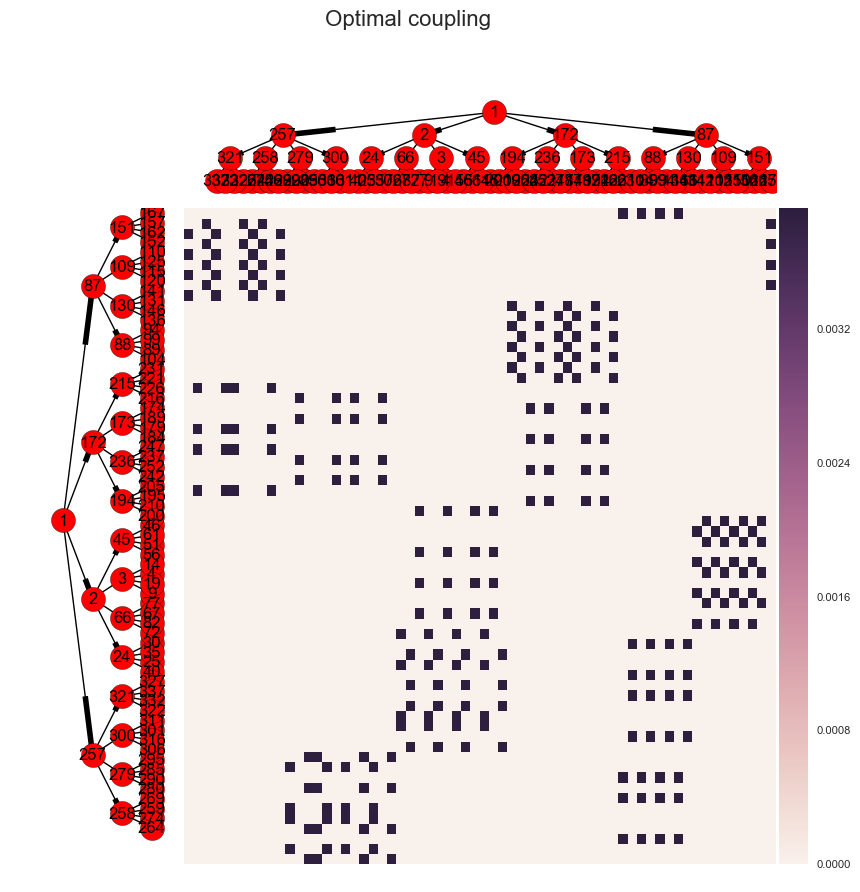

In [85]:
sns.set_context("paper")
f = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(2, 3, width_ratios=[1,4,0.2], height_ratios=[0.7,4])
gs.update(wspace=0.01, hspace=0.01)

ax2 = plt.subplot(gs[1])
sns.set_style('white')
ax2.axis('off')
plt.xlim( -0.05,1 )
nx.draw_networkx(graph2.tree,pos=graph2.hierarchy_pos(graph2.nx_graph,1),flip=True)
ax3 = plt.subplot(gs[3])
plt.ylim( -0.05,1 )
nx.draw_networkx(graph1.tree,pos=graph1.hierarchy_pos(graph1.nx_graph,1,rotate=True))
ax3.axis('off')
ax5 = plt.subplot(gs[5])
ax4 = plt.subplot(gs[4])
sns.heatmap(np.flipud(transpwgw),annot=True,fmt='.2f',cbar_ax=ax5,xticklabels=False,yticklabels=False)
f.suptitle('Optimal coupling', fontsize=16)
plt.show()

In [132]:
np.sum(transp*M)

0.73864299101093978

In [133]:
np.sum(transpwgw*M)

0.74176236266288853

# 1-NN classification

### Create Dataset

In [1]:
import seaborn as sns
import numpy as np
import os,sys
module_path = os.path.abspath(os.path.join('/Users/vayer/Documents/OT/Python/GW_tests/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graph import *
import copy
import utils
import ot
import WGW_2 as wgw
import random
import NN
import time

On va d'abord essayer avec deux classes

In [2]:
dataset_name=["airplane", "baseballdiamond"]    

In [3]:
mypath='/Users/vayer/Documents/OT/Python/mercedData/'+dataset_name[0]
onlyfiles = utils.read_files(mypath)
data_classe1=[]
for f in onlyfiles :
    G=Graph()
    G.build_Xml_tree(mypath+'/'+f,max_depth=5)
    data_classe1.append((G,0)) 

In [4]:
mypath='/Users/vayer/Documents/OT/Python/mercedData/'+dataset_name[1]
onlyfiles = utils.read_files(mypath)
data_classe2=[]
for f in onlyfiles :
    G=Graph()
    G.build_Xml_tree(mypath+'/'+f,max_depth=5)
    data_classe2.append((G,1)) 

In [5]:
ratio=0.5

In [6]:
x_train_1=random.sample(data_classe1,int(ratio*len(data_classe1)))
x_test_1=list(set(data_classe1).difference(set(x_train_1)))

In [7]:
x_train_2=random.sample(data_classe2,int(ratio*len(data_classe2)))
x_test_2=list(set(data_classe2).difference(set(x_train_2)))

In [8]:
x_train=[]
y_train=[]
for element in x_train_1+x_train_2 :
    x_train.append(element[0])
    y_train.append(element[1])

In [9]:
x_test=[]
y_test=[]
for element in x_test_1+x_test_2 :
    x_test.append(element[0])
    y_test.append(element[1])

In [10]:
def tree_distance(alpha,epsilon):

    def dist(graph1,graph2):
        leaves1=graph1.return_leaves(graph1.tree)
        leaves2=graph2.return_leaves(graph2.tree)
        C1=graph1.distance_matrix(graph1.nx_graph,nodeOfInterest=leaves1)
        C2=graph2.distance_matrix(graph2.nx_graph,nodeOfInterest=leaves2)
        t1masses = np.ones(len(leaves1))/len(leaves1)
        t2masses = np.ones(len(leaves2))/len(leaves2)
        x1=graph1.leaves_matrix_attr()
        x2=graph2.leaves_matrix_attr()
        M=ot.dist(x1,x2)
        M= M/np.max(M)

        transpwgw= wgw.wgw(M,C1,C2,t1masses,t2masses,'square_loss',epsilon,alpha,max_iter=500,verbose=False,log=False)

        return np.sum(transpwgw*M)
    
    return dist
    

In [11]:
alphas=np.linspace(0,700,30)
epsilons= np.linspace(0.01,20,50)

In [12]:
alpha = alphas[10]
epsilon=epsilons[13]

In [13]:
local_metric=tree_distance(alpha,epsilon)

In [14]:
one_nn=NN.Generic1NNClassifier(similarity_measure=local_metric,parallel=True)

In [15]:
one_nn.fit(x_train,y_train)

Generic1NNClassifier(parallel=True, similarity_measure=None,
           the_lower_the_better=False)

In [ ]:
start_time = time.time()
classes=one_nn.predict(x_test[0:1])
end_time = time.time()

In [19]:
print ("time to perform one pred: ",  end_time-start_time)

time to perform one pred:  197.8112199306488


In [ ]:
start_time = time.time()
k_fold = StratifiedKFold(y=y_train, n_folds=2)
cv_scores = {}
for param1 in [0.01]:  # TODO: here, put parameter values for param1 to be cross-validated
    for param2 in [ 1e-4]: #  # TODO: here, put parameter values for param2 to be cross-validated
        start_time = time.time()
        clf = Generic1NNClassifier(similarity_measure=parameter_less_function(param1=param1, param2=param2), the_lower_the_better=the_lower_the_better)
        l_scores = []
        for idx_subtrain, idx_valid in k_fold:
            pred = clf.fit(x_train[idx_subtrain], y_train[idx_subtrain]).predict(x_train[idx_valid])
            l_scores.append(float(numpy.sum(pred == y_train[idx_valid])) / len(y_train[idx_valid]))
        cv_scores[param1, param2] = numpy.mean(l_scores)
        print("--- %s seconds ---" % (time.time() - start_time))
        print ("params :", param1, param2, " accuracy :", numpy.mean(l_scores))
if the_lower_the_better:
    best_param1, best_param2 = dict_argmin(cv_scores)
else:
    best_param1, best_param2 = dict_argmax(cv_scores)

best_param1, best_param2 = dict_argmax(cv_scores) #LC
end_time = time.time()
print ("time to perform the entire grid search: ",  start_time-end_time)
print ("best param: ", best_param1, best_param2)
#%%